In [89]:
import jax
import jax.numpy as jnp
from jaxlib.xla_extension import ArrayImpl
import flax
from flax.training import train_state
from flax.training.train_state import TrainState
from flax import linen as nn
from flax.training import checkpoints
from jaxtyping import Array, Float
import numpy as np
import optax
import os
import math 
import numpy as np
import torch
from typing import Any
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm, trange


In [90]:
DATASET_NAME = "swiss"
#DATASET_NAME = "moons"
N_EPOCHS = 1_000
rng = jax.random.PRNGKey(0)

# Interpolants

In [91]:

def interpolant(x0: Float[Array, "N"] , x1: Float[Array, "N"], t: float) -> Float[Array, "N"]:
    return x0 + (x1 - x0) * t

velocity = jax.jacrev(interpolant, argnums=2)
velocity = jax.vmap(velocity)
interpolant = jax.vmap(interpolant)


## Neural Networks

In [92]:
def time_encoding(t: float, n_frequencies: int) -> Float[Array, "2 n_freq"]:
    phases = 2 * jnp.arange(n_frequencies) * jnp.pi * t
    return jnp.concatenate([jnp.sin(phases), jnp.cos(phases)])

time_encoding = jax.vmap(time_encoding, in_axes=(0, None))


class MLP(nn.Module):
    h_dim: list[int]
    out_dim: int
    n_frequencies: int

    @nn.compact
    def __call__(self, t: Float[Array, "B"], x: Float[Array, "B N"]) -> Float[Array, "B N"]:
        x = jnp.concatenate([x, time_encoding(t, self.n_frequencies)], axis=-1)
        for h in self.h_dim:
            x = nn.Dense(h)(x)
            x = nn.relu(x)
        return nn.Dense(self.out_dim)(x)

In [93]:
cfm = MLP(h_dim=[128, 128, 128], out_dim=2, n_frequencies=5)
rng, inp_rng, t_rng, init_rng = jax.random.split(rng, 4)
inp = jax.random.normal(inp_rng, (8, 2))
t = jax.random.uniform(t_rng, (8, 1))
params = cfm.init(init_rng, t, inp)

In [94]:
print(type(rng))

<class 'jaxlib.xla_extension.ArrayImpl'>


## Dataset


In [95]:
class SimpleDataset(Dataset):
  def __init__(self, n_points: int, dataset: str) -> None:
    if dataset == "moons":
      data, _ = make_moons(n_points, noise=0.15)
    elif dataset == "swiss":
      data, _ = make_swiss_roll(n_points, noise=0.15)
      data = data[:, [0, 2]] / 10.0
    
    self.data = StandardScaler().fit_transform(data)

  def __len__(self) -> None:
    return len(self.data)

  def __getitem__(self, idx: int) -> Float[Array, "N"]:
    return self.data[idx]

ds = SimpleDataset(100_000, DATASET_NAME)
numpy_collate = lambda x: np.stack(x)
dl = DataLoader(ds, batch_size=2048, shuffle=True, collate_fn=numpy_collate)

## Training

In [96]:
optimizer = optax.adam(learning_rate=1e-2)
cfm_state = train_state.TrainState.create(apply_fn=cfm.apply, params=params, tx=optimizer)

In [97]:
def loss_fn(state: TrainState, params: dict[str, Any], x1: Float[Array, "B N"], rng: ArrayImpl) -> Float[Array, "1"]:
    rng, t_rng, noise_rng = jax.random.split(rng, 3)
    # sample x0
    x0 = jax.random.normal(noise_rng, x1.shape)
    t = jax.random.uniform(t_rng, (x1.shape[0]))

    # sample xt
    xt = interpolant(x0, x1, t)
    vt = velocity(x0, x1, t)
    vt_pred = state.apply_fn(params, t, xt)
    loss = jnp.mean((vt_pred - vt) ** 2)

    return loss


@jax.jit
def train_step(state: TrainState, batch: Float[Array, "B N"], step_rng: ArrayImpl) -> tuple[TrainState, Float[Array, "1"]]:
    grad_fn = jax.value_and_grad(loss_fn, argnums=1)
    loss, grads = grad_fn(state, state.params, batch, step_rng)
    state = state.apply_gradients(grads=grads)

    return state, loss


@jax.jit
def eval_step(params: dict[str, Any], batch: Float[Array, "B N"], step_rng: ArrayImpl) -> Float[Array, "1"]:
    return loss_fn(model_state, params, batch, step_rng)

In [98]:
def train_model(state: TrainState, data_loader: DataLoader, rng: ArrayImpl, num_epochs: int=100) -> TrainState:
    for epoch in trange(num_epochs):
        for batch in data_loader:
            rng, step_rng = jax.random.split(rng)
            state, loss = train_step(state, batch, step_rng)

    return state

In [99]:
ckpt_dir = os.path.join(os.getcwd(), "checkpoints")
trained_model_state = train_model(cfm_state, dl,rng,  num_epochs=N_EPOCHS)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s]


In [100]:
def sample(n_points: int, rng: ArrayImpl, cfm: MLP, model_state: TrainState, n_steps: int=100) -> list[Float[Array, "S N"]]:
    rng, noise_rng = jax.random.split(rng)
    xt = jax.random.normal(noise_rng, (n_points, 2))
    trajectory = [xt]
    timesteps = jnp.linspace(0, 1, n_steps)
    for t_current, t_next in zip(timesteps[:-1], timesteps[1:]):
        t = jnp.ones(n_points) * t_current
        xt = xt + (t_next - t_current) * cfm.apply(model_state.params, t, xt) 
        trajectory.append(xt)

    return trajectory


trajectory = sample(n_points=2000, rng=rng, cfm=cfm, model_state=trained_model_state, n_steps=500)



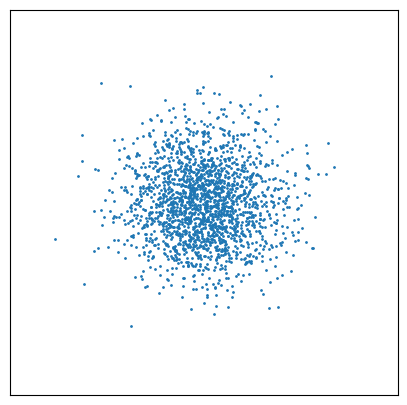

In [101]:
# init the figure
N_FRAMES = 100
END_PADDING = 1000
frames = trajectory[::len(trajectory) // N_FRAMES]
pad_frames = frames + [frames[-1]] * END_PADDING
fig, ax = plt.subplots(figsize=(5,5))
# remove ticks
def update(i: int) -> None:
    ax.clear()
    ax.scatter(pad_frames[i][:, 0], pad_frames[i][:, 1], s=1)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xticks([])
    ax.set_yticks([])

ani = animation.FuncAnimation(fig, update, frames=N_FRAMES + END_PADDING, interval=1)
ani.save(f'{DATASET_NAME}_{N_EPOCHS}.gif', writer='pillow')